In [67]:
%load_ext autoreload
%autoreload
from factory import *
import torch
from model import Unet
from catalyst.dl.callbacks import CriterionCallback, EarlyStoppingCallback
from catalyst.dl.runner import SupervisedRunner
from pytorch_toolbelt import losses as L
import collections
from pytorch_toolbelt.utils.catalyst import * 
from metrics import *
import custom_tta as tta
from pytorch_toolbelt.inference.tiles import *
import matplotlib.pyplot as plt
from viz_utils import *
from tqdm import tqdm
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of factory failed: Traceback (most recent call last):
  File "/home/skolchen/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/skolchen/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/skolchen/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/skolchen/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/skolchen/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    frame = next(frame_nfo.frame for frame_nfo in inspect.stack()
StopIteration
]


In [ ]:
import pixiedust

In [68]:
encoder_name = 'resnet34'
sample_submission_path = 'data/sample_submission.csv'
train_df_path = 'data/train.csv'
data_folder = "data/train_images/"
test_data_folder = "data/test_images/"
base_exp_name = '{}_with_corase_matrix_deeper'.format(encoder_name)
log_dir = 'logs/{}_pretrain/'.format(base_exp_name)
batch_size = 32
batch_size_val = 8
crop_size = 256
num_workers = 16
num_epochs = 100
tta_type = None
output_channels = 4

In [3]:
dataloader_train = provider(
    data_folder=data_folder,
    df_path=train_df_path,
    phase='train',
    transforms=light_augmentations(crop_size),
    batch_size=batch_size,
    num_workers=num_workers, 
    prepare_coarse=True, prepare_edges=False)
dataloader_val = provider(
    data_folder=data_folder,
    df_path=train_df_path,
    phase='val',
    transforms=validation_augmentations(),
    batch_size=batch_size_val,
    num_workers=num_workers, 
    prepare_coarse=True, prepare_edges=False)

In [4]:
loaders = collections.OrderedDict()
loaders["train"] = dataloader_train
loaders["valid"] = dataloader_val
runner = SupervisedRunner(input_key = 'features',
                          output_key =  None,
                          input_target_key = None)

In [5]:
model = Unet(classes=output_channels, 
             encoder_name=encoder_name,
             encoder_weights='imagenet')
loss_f = get_loss('bce_jaccard')
optimizer = get_optimizer('radam', model.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                 milestones=[10, 30, 50, 70, 90],
                                                 gamma=0.5)

In [6]:
if tta_type=='flipr':
    model = tta.TTAWrapper(model, tta.fliplr_image2mask)
if tta_type=='d4':
    model = tta.TTAWrapper(model, tta.d4_image2mask)    

Visualize the model

In [ ]:
inputs = torch.randn(1,3,256,256)
y = model(Variable(inputs))['logits_coarse']
g = make_dot(y, model.state_dict())
g.view()

In [ ]:
#%%pixie_debugger
runner.train(
    model=model,
    criterion=loss_f,
    optimizer=optimizer,
    scheduler=scheduler,
    callbacks=[
        CriterionCallback(input_key="targets",
                     output_key="logits",
                     prefix="loss",
                     criterion_key=None),
        CriterionCallback(input_key="coarse_targets",
                          output_key="logits_coarse",
                          prefix="loss_coarse",
                          criterion_key=None, multiplier = 0.5),
        CriterionCallback(input_key="targets_combined",
                          output_key="logits_combined",
                          prefix="loss_combined",
                          criterion_key=None),
        CriterionCallback(input_key="coarse_targets_combined",
                          output_key="logits_coarse_combined",
                          prefix="loss_coarse_combined",
                          criterion_key=None, multiplier = 0.5),
        JaccardScoreCallback(mode='multilabel',
                             input_key='targets', 
                             output_key="logits",
                             prefix='jaccard_targets'),
        JaccardScoreCallback(mode='binary',
                             input_key='targets_combined', 
                             output_key="logits_combined",
                             prefix='jaccard_targets_combined'),
        JaccardScoreCallback(mode='multilabel',
                             input_key='coarse_targets', 
                             output_key="logits_coarse",
                             prefix='jaccard_targets_coarse'),
        JaccardScoreCallback(mode='binary',
                             input_key='coarse_targets_combined', 
                             output_key="logits_coarse_combined",
                             prefix='jaccard_targets_combined_coarse'),
        JaccardMetricPerImage(),
        OptimalThreshold(),
        EarlyStoppingCallback(25, metric='loss', minimize=True)
    ],
    loaders=loaders,
    logdir=log_dir,
    num_epochs=num_epochs,
    verbose=True
)

Load best epochs

In [9]:
model.load_state_dict(torch.load(os.path.join(log_dir,'checkpoints/best.pth'))['model_state_dict'])
model.cuda()
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [75]:
use_tiles_predictions = True
tile_step = 56
target_shape = (256, 1600)

In [80]:
train_df, val_df = return_masks(train_df_path)
images_id = []
predictions = []
if use_tiles_predictions:
        tiler = ImageSlicer(target_shape, tile_size=(crop_size, crop_size),
                        tile_step=(tile_step, tile_step), weight='mean')
for image_idx in tqdm(range(len(val_df.index.values))):
    image = cv2.imread(os.path.join(data_folder, val_df.index.values[image_idx]))
    augmented  = validation_augmentations()(image=image)
    image_processed = augmented['image']
    if use_tiles_predictions:
        merger = CudaTileMerger(tiler.target_shape, output_channels, tiler.weight)
        tiles = [tensor_from_rgb_image(tile) for tile in tiler.split(image_processed)]
        for tiles_batch, coords_batch in DataLoader(list(zip(tiles, tiler.crops)), 
                                                    batch_size=batch_size,
                                                    pin_memory=True):
            tiles_batch = tiles_batch.float().cuda()
            with torch.no_grad():
                pred_batch = nn.Sigmoid()(model(tiles_batch)['logits'])
            merger.integrate_batch(pred_batch, coords_batch)
        merged_mask = np.moveaxis(merger.merge().cpu().numpy(), 0, -1)
    else:
        with torch.no_grad():
            image_processed = image_processed.transpose((2, 0, 1))
            image_processed = torch.from_numpy(np.expand_dims(image_processed,0)).cuda()
            #take only logits
            merged_mask = nn.Sigmoid()(model(image_processed)['logits'])
            merged_mask = np.moveaxis((merged_mask[0].cpu().numpy()), 0, -1)  
    predictions.append(merged_mask)
    images_id.append(val_df.index.values[image_idx])

100%|██████████| 2514/2514 [04:12<00:00,  9.94it/s]


In [72]:
dict_of_predictions = dict(zip(images_id, predictions))

Prepare GT masks

In [14]:
gt_masks = []
for image_idx in tqdm(range(len(val_df.index.values))):
    image_name =  val_df.index.values[image_idx]
    labels = val_df.loc[image_name,:][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    gt_masks.append(masks)

100%|██████████| 2514/2514 [00:05<00:00, 466.58it/s]


In [45]:
dict_of_gt_masks = dict(zip(images_id, gt_masks))

Calculate overall dice score + per-image dice score

In [81]:
min_area = [600, 600, 1000, 2000]
dice_preds = []
images_per_defect = []
thr_prediction = 0.5
for idx in tqdm(range(len(predictions))):
    for defect_type in range(4):
        mask_pred =  (predictions[idx][...,defect_type] > thr_prediction).astype(int)
        mask_gt = gt_masks[idx][...,defect_type]
        if mask_pred.sum() < min_area[defect_type]:
            mask_pred = np.zeros(mask_pred.shape)
        dice_gt_pr = dice(mask_gt,
                          mask_pred,
                          empty_score=1.0)
        dice_preds.append(dice_gt_pr)
        images_per_defect.append(images_id[idx])
print('DICE validation {}'.format(np.mean(dice_preds)))

100%|██████████| 2514/2514 [00:29<00:00, 85.54it/s]

DICE validation 0.9292319556875874


In [82]:
dice_per_image = pd.DataFrame({'image_id':images_per_defect,'dice_per_defect':dice_preds})
dice_per_image = pd.DataFrame(dice_per_image.groupby(['image_id']).agg({'dice_per_defect': ['min', 'mean']}))
dice_per_image.columns = ['_'.join(col).strip() for col in dice_per_image.columns.values]
dice_per_image.sort_values(by=['dice_per_defect_mean'],inplace=True)
dice_per_image.head()

,dice_per_defect_min,dice_per_defect_mean
image_id,,
b0038b54c.jpg,0.0,0.000000
af5c06a20.jpg,0.0,0.250000
34a5114d6.jpg,0.0,0.395763
6fdf2d1be.jpg,0.0,0.457719
b4805acf7.jpg,0.0,0.500000


Visualize bad examples

Mask size for defect class 1 : 0
Defect class 1, dice 1.0
Mask size for defect class 2 : 0
Defect class 2, dice 1.0
Mask size for defect class 3 : 46822
Defect class 3, dice 0.0
Mask size for defect class 4 : 9387
Defect class 4, dice 0.7178031553237838


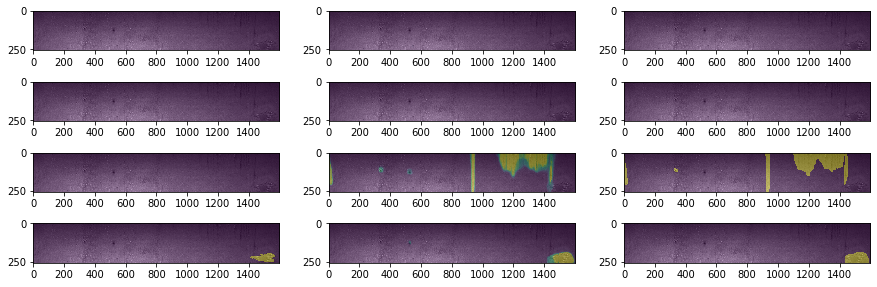

In [96]:
idx = 91
image_name = dice_per_image.index.values[idx]
image = cv2.imread(os.path.join(data_folder, image_name))
f, ax = plt.subplots(4,3, figsize=(15,5))
for defect_type in range(4):
    #generate mask 
    gt_mask = dict_of_gt_masks[image_name]
    prediction = dict_of_predictions[image_name]
    ax[defect_type,0].imshow(image)
    ax[defect_type,0].imshow(gt_mask[...,defect_type], alpha=0.4)
    ax[defect_type,1].imshow(image)
    ax[defect_type,1].imshow(prediction[...,(defect_type)],vmin=0, vmax=1.0, alpha=0.4)
    mask_pred =  (prediction[...,(defect_type)] > 0.5).astype(int)
    print('Mask size for defect class {} : {}'.format(defect_type+1, mask_pred.sum()))
    if mask_pred.sum() < min_area[defect_type]:
        mask_pred = np.zeros(mask_pred.shape)
    ax[defect_type,2].imshow(image)
    ax[defect_type,2].imshow(mask_pred, alpha=0.4)
    dice_gt_pr = dice(gt_mask[...,defect_type],
                      mask_pred,
                      empty_score=1.0)
    print('Defect class {}, dice {}'.format(defect_type+1, dice_gt_pr))